# Navier Strokes

The Navier-Stokes equations are a set of partial differential equations that describe the motion of fluid substances such as liquids and gases. These equations are fundamental to fluid mechanics and are used to model the behavior of fluids in various contexts, from weather patterns and ocean currents to air flow over an aircraft wing and blood flow in the human body.


# Install NVIDIA Modulus

In [7]:
!pip install nvidia-modulus nvidia-modulus-sym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.9/320.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.9/291.9 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.2/210.2 kB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.1/772.1 kB 39.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 6.9 MB/s eta 0:00:00
     ━━

# Import required

run after restarting the session

In [2]:
import os
import warnings
import torch # important for visualization part of the nb
import matplotlib.pyplot as plt
from sympy import Symbol, Eq, Abs

# Navier Strokes PDEs

In [3]:
from modulus.sym.eq.pdes.navier_stokes import NavierStokes

In [4]:
ns = NavierStokes(nu=0.01, rho=1.0, dim=2, time=False)

In [5]:
ns.dim

2

In [6]:
ns.equations

{'continuity': 1.0*Derivative(u(x, y), x) + 1.0*Derivative(v(x, y), y),
 'momentum_x': 1.0*u(x, y)*Derivative(u(x, y), x) + 1.0*v(x, y)*Derivative(u(x, y), y) + Derivative(p(x, y), x) - 0.01*Derivative(u(x, y), (x, 2)) - 0.01*Derivative(u(x, y), (y, 2)),
 'momentum_y': 1.0*u(x, y)*Derivative(v(x, y), x) + 1.0*v(x, y)*Derivative(v(x, y), y) + Derivative(p(x, y), y) - 0.01*Derivative(v(x, y), (x, 2)) - 0.01*Derivative(v(x, y), (y, 2))}

In [7]:
ns.pprint()

continuity: 1.0*Derivative(u(x, y), x) + 1.0*Derivative(v(x, y), y)
momentum_x: 1.0*u(x, y)*Derivative(u(x, y), x) + 1.0*v(x, y)*Derivative(u(x, y), y) + Derivative(p(x, y), x) - 0.01*Derivative(u(x, y), (x, 2)) - 0.01*Derivative(u(x, y), (y, 2))
momentum_y: 1.0*u(x, y)*Derivative(v(x, y), x) + 1.0*v(x, y)*Derivative(v(x, y), y) + Derivative(p(x, y), y) - 0.01*Derivative(v(x, y), (x, 2)) - 0.01*Derivative(v(x, y), (y, 2))


In [8]:
ns.equations['continuity']

    ∂                 ∂          
1.0⋅──(u(x, y)) + 1.0⋅──(v(x, y))
    ∂x                ∂y         

In [9]:
ns.equations['momentum_x']

                                                                         2    
            ∂                         ∂             ∂                   ∂     
1.0⋅u(x, y)⋅──(u(x, y)) + 1.0⋅v(x, y)⋅──(u(x, y)) + ──(p(x, y)) - 0.01⋅───(u(x
            ∂x                        ∂y            ∂x                   2    
                                                                       ∂x     

               2         
              ∂          
, y)) - 0.01⋅───(u(x, y))
               2         
             ∂y          

In [10]:
ns.equations['momentum_y']

                                                                         2    
            ∂                         ∂             ∂                   ∂     
1.0⋅u(x, y)⋅──(v(x, y)) + 1.0⋅v(x, y)⋅──(v(x, y)) + ──(p(x, y)) - 0.01⋅───(v(x
            ∂x                        ∂y            ∂y                   2    
                                                                       ∂x     

               2         
              ∂          
, y)) - 0.01⋅───(v(x, y))
               2         
             ∂y          

# Neural Network

In [37]:
from modulus.sym.models.fully_connected import FullyConnectedArch
from modulus.sym.models.activation import Activation
from modulus.sym.key import Key

# Explicit declaration
flow_net = FullyConnectedArch(
    # Science & Engineering Knowledge
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    # Neural Networks Knowledge (You don't need to know...)
    layer_size=512,
    nr_layers=6,
    skip_connections=False,
    activation_fn=Activation.SILU,
    adaptive_activations=False,
    weight_norm=True
)

In [38]:
flow_net

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=512, bias=True)
      )
      (1-5): 5 x FCLayer(
        (linear): WeightNormLinear(in_features=512, out_features=512, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=512, out_features=3, bias=True)
    )
  )
)

In [13]:
nodes = ns.make_nodes() + [flow_net.make_node(name="flow_network")]

In [14]:
nodes

# Geometry or 'The Domain'

In [15]:
from modulus.sym.geometry.primitives_2d import Rectangle

height = 0.1
width = 0.1
x, y = Symbol('x'), Symbol('y')
rec = Rectangle((-width/2, -height/2), (width/2, height/2))

In [16]:
rec

# The meat of science and engineering CONSTRAINTS

In [17]:
from modulus.sym.domain import Domain

ldc_domain = Domain()

## Boundary Constraints

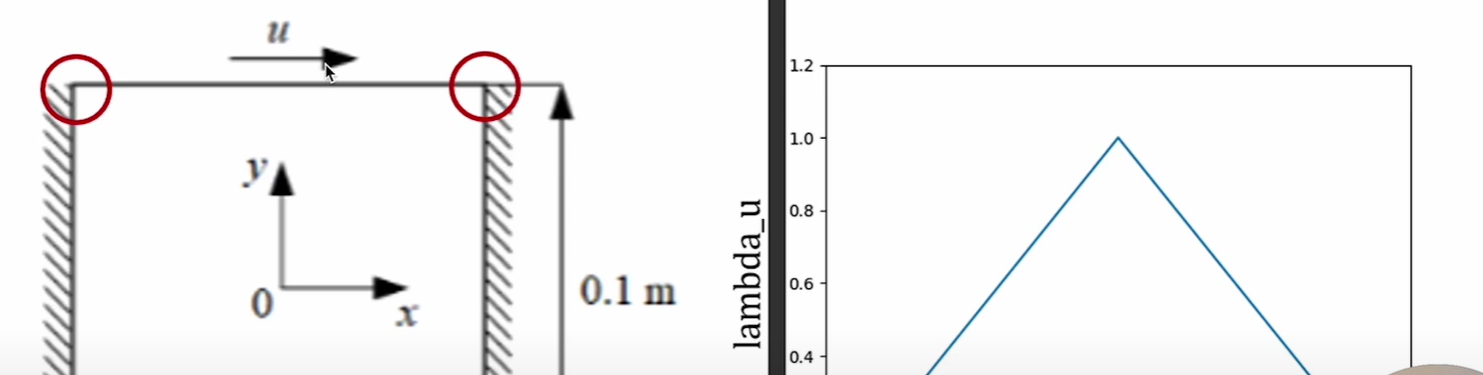

In [18]:
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
    PointwiseConstraint
)

In [19]:
# top wall
top_wall = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={
        "u": 1.0, "v": 0
    },
    # batch_size=cfg.batch_size.TopWall
    batch_size=1000,
    lambda_weighting={"u": 1.0 - 20 * Abs(x), "v": 1.0},  # weight edges to be zero
    criteria=(Eq(y, height / 2))  # y = 0.05
)

# no slip
no_slip = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={
        "u": 0, "v": 0
    },
    batch_size=1000,
    criteria = y < height / 2
)

In [20]:
# science engineering here
ldc_domain.add_constraint(top_wall, "top_wall")
ldc_domain.add_constraint(no_slip, "no_slip")

# Interior constraints

In [21]:
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={
        "continuity": 0, "momentum_x": 0, "momentum_y": 0
    },
    batch_size=4000,
    lambda_weighting={
        "continuity": Symbol("sdf"),
        "momentum_x": Symbol("sdf"),
        "momentum_y": Symbol("sdf")
    }
)
ldc_domain.add_constraint(interior, "interior")

https://docs.nvidia.com/deeplearning/modulus/modulus-sym/user_guide/theory/recommended_practices.html#:~:text=Spatial%20Weighting%20of%20Losses%20(SDF%20weighting)&text=Another%20example%20is%20weighting%20the,solution%20of%20the%20differential%20equation.

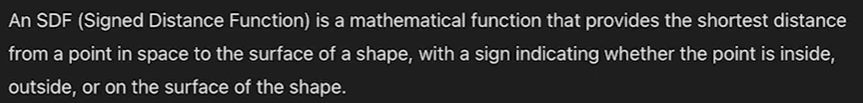

# Solver Configuration

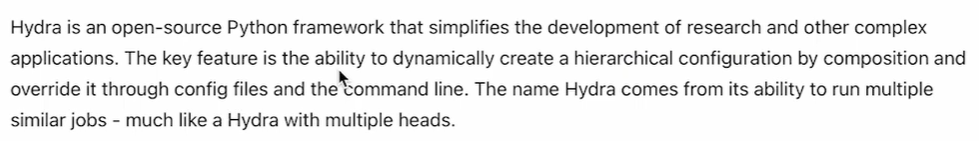

In [22]:
%%writefile config.yaml

defaults:
  - modulus_default
  - arch: fully_connected
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

scheduler:
  decay_rate: 0.95
  decay_steps: 4000

training:
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  max_steps: 10000

batch_size:
  TopWall: 1000
  NoSlip: 1000
  Interior: 4000

graph:
  func_arch: true


Writing config.yaml


In [33]:
import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.utils import compose
from modulus.sym.hydra.config import ModulusConfig

cfg = compose(config_path=".", config_name="config")
cfg.network_dir = "outputs" # set the network directory for checkpoints
print(to_yaml(cfg))

/usr/local/lib/python3.10/dist-packages/modulus/sym/hydra/utils.py:150: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch:
  fully_connected:
    arch_type: fully_connected
    input_keys: ???
    ou

# Create Solver

In [34]:
from modulus.sym.solver import Solver

slv = Solver(cfg, ldc_domain)

# Run the solver

First confiure the loggin to see the steps!!

In [35]:
import logging

# Create a function to configure logging
def configure_logging():
    # Get the root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)

    # Remove all existing handlers
    while logger.handlers:
        logger.handlers.pop()

    # Create a stream handler
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)

    # Create a formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    stream_handler.setFormatter(formatter)

    # Add the handler to the logger
    logger.addHandler(stream_handler)

# Configure logging
configure_logging()

# Test logging
logging.debug("Logging is configured correctly.")


2024-07-05 01:54:55,766 - root - DEBUG - Logging is configured correctly.


In [ ]:
# slv.solve()

# Load Model From File

In [39]:
torch.load('./outputs/optim_checkpoint.0.pth').keys()

dict_keys(['step', 'optimizer_state_dict', 'aggregator_state_dict', 'scheduler_state_dict', 'scaler_state_dict'])

In [40]:
torch.load('./outputs/flow_network.0.pth').keys()

odict_keys(['_impl.layers.0.linear.weight', '_impl.layers.0.linear.weight_g', '_impl.layers.0.linear.bias', '_impl.layers.1.linear.weight', '_impl.layers.1.linear.weight_g', '_impl.layers.1.linear.bias', '_impl.layers.2.linear.weight', '_impl.layers.2.linear.weight_g', '_impl.layers.2.linear.bias', '_impl.layers.3.linear.weight', '_impl.layers.3.linear.weight_g', '_impl.layers.3.linear.bias', '_impl.layers.4.linear.weight', '_impl.layers.4.linear.weight_g', '_impl.layers.4.linear.bias', '_impl.layers.5.linear.weight', '_impl.layers.5.linear.weight_g', '_impl.layers.5.linear.bias', '_impl.final_layer.linear.weight', '_impl.final_layer.linear.bias'])

In [44]:
# Load optimizer checkpoint
checkpoint = torch.load('./outputs/optim_checkpoint.0.pth')

# Try to load the flow network checkpoint
try:
    checkpoint = torch.load('./outputs/flow_network.0.pth')
    checkpoint.eval()
except AttributeError as error:
    print(error)
    # If there's an AttributeError, it means the checkpoint object might be a dictionary.
    flow_net.load_state_dict(checkpoint['state_dict'])


'collections.OrderedDict' object has no attribute 'eval'


KeyError: 'state_dict'